In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
cd /content/gdrive/My Drive/IRP

/content/gdrive/My Drive/IRP


[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 32 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[  0  32  64 224]
(256, 320)
{'Bipolar_Forceps': {'area': 10029.0, 'upperleft': (4, 5), 'length': -222, 'height': -158}, 'Prograsp_Forceps': {'area': 2566.0, 'upperleft': (198, 4), 'length': -117, 'height': -71}}
(256, 320)
{'Bipolar_Forceps': {'area': 10029.0, 'upperleft': (4, 5), 'length': -222, 'height': -158}, 'Prograsp_Forceps': {'area': 2566.0, 'upperleft': (198, 4), 'length': -117, 'height': -71}}


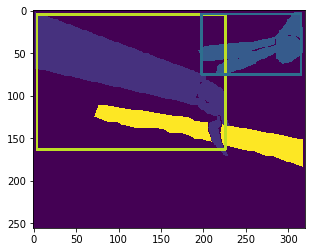

In [55]:
import re
import urllib
from bs4 import BeautifulSoup
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utility import inference
import argparse
import urllib
import requests
def get_args():
	parser = argparse.ArgumentParser(description = 'crawler')
	parser.add_argument("--url", type=str, required=True, help="url")
	args = parser.parse_args()
	return args

def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = requests.get(url)
    image = np.asarray(bytearray(resp.content), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # return the image
    return image
def huamethod(imgnet,img,count):
    res = {}
    mydict = {32: "Bipolar_Forceps",
              64: "Prograsp_Forceps",
              96: "Large_Needle_Driver",
              128: "Vessel_Sealer",
              160: "Grasping_Retractor",
              192: "Monopolar_Curved_Scissors",
              224: "Other"}
    classes = np.unique(img)
    print(classes)
    for num in classes:
        if num == 0 or num == 224:
            continue
        else:
            newimg = np.copy(img)
            print (newimg.shape)
            for i in range(newimg.shape[0]):
                for j in range(newimg.shape[1]):
                    if newimg[i][j] != num:
                        newimg[i][j] = 0
            leftmost = 0
            rightmost = 0
            highmost = 0
            lowmost = 0
            dilection = newimg
            area = np.sum(dilection) / num
            for i in range(dilection.shape[0]):
                for j in range(dilection.shape[1]):
                    if dilection[i][j] == num:
                        lowmost = i
                        break
            for i in range(dilection.shape[1]):
                for j in range(dilection.shape[0]):
                    if dilection[j][i] == num:
                        rightmost = i
                        break
            for i in range(dilection.shape[0] - 1, 0, -1):
                for j in range(dilection.shape[1]):
                    if dilection[i][j] == num:
                        highmost = i
                        break
            for i in range(dilection.shape[1] - 1, 0, -1):
                for j in range(dilection.shape[0]):
                    if dilection[j][i] == num:
                        leftmost = i
                        break
            cv2.rectangle(imgnet, (leftmost, highmost), (rightmost, lowmost),
                          (255 * random.random(), 255 * random.random(), 255 * random.random()), 2)
            res[mydict[num]] = {'area': area, 'upperleft': (leftmost, highmost), 'length': leftmost - rightmost,
                                'height': highmost - lowmost}
    print(res)
    path = 'F:/temp/'+str(count)+'.jpg'
    cv2.imwrite(path,imgnet)

args = get_args()
url = args.url
html = requests.get(url)
html.encoding = 'utf-8'
urllist = re.findall('img src="(.*?)"',html.text,re.S)
i=0
for link in urllist:
    print(link)
    if not link.startswith('http'):
      link = url+link
    imgnet = url_to_image(link)
    path ='/content/gdrive/My Drive/IRP/[epoch50]_ir_.pth'
    img = inference(imgnet,path)
    print(img.shape)
    plt.imshow(img,cmap='gray')
    if 32 in np.unique(img) or 64 in np.unique(img) or 96 in np.unique(img) or 128 in np.unique(
            img) or 160 in np.unique(img) or 192 in np.unique(img) or 32 in np.unique(img):
        huamethod(imgnet,img,i)
        i = i+1
    else:
        continue
print("over")